In [1]:
from bson.son import SON
import json
from pymongo import MongoClient
from bson.objectid import ObjectId
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
from matplotlib import rcParams
import seaborn as sns
from datetime import datetime
from sshtunnel import SSHTunnelForwarder
import pymongo

# Connect to remote mongodb

In [2]:
with open('keys.json') as k:
    keys = json.loads(k.read())
    MONGO_HOST = keys["SSH"]["MONGO_HOST"] # i.e. 10.9.13.14
    MONGO_DB = keys["SSH"]["MONGO_DB"] # i.e. dm_project 
    MONGO_USER = keys["SSH"]["MONGO_USER"] # i.e. studente
    MONGO_PASS = keys["SSH"]["MONGO_PASS"] # i.e. la password della vm

server = SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_password=MONGO_PASS,
    remote_bind_address=('127.0.0.1', 27017)
)

server.start() # remember to stop

client = pymongo.MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port

db = client[MONGO_DB]

db.list_collection_names()

['system.indexes', 'twitch', 'twitter']

# Twitch

### Get daily data 

In [4]:
pipelined = [{"$unwind": "$data"},
            { "$group": {
                "_id": {"name": "$data.game_name",
                        "year" :  { "$substr" : ["$timestamp", 0, 4 ] }, 
                        "month" : { "$substr" : ["$timestamp", 5, 2 ] },     
                        "day" :   { "$substr" : ["$timestamp", 8, 2 ] } },
                "avgViewers": { "$avg": '$data.viewers'}
            }},
            {"$sort": {"_id": 1} }]

In [5]:
# this is very slow

start = datetime.now()
resultd = list(db.twitch.aggregate(pipelined, allowDiskUse = True))
end = datetime.now()
(end-start).total_seconds()

36.874321

In [7]:
dfd = json_normalize(resultd)
dfd = dfd.rename(index=str, columns={"_id.name": "name",
                                  "_id.day": "day","_id.month": "month","_id.year": "year"})
dfd = dfd[['name','day', 'month', 'year', 'avgViewers']]

In [8]:
dfd.head()

,name,day,month,year,avgViewers
0,8 To Glory - The Official Game of the PBR,14,06,2019,1.000000
1,8 To Glory - The Official Game of the PBR,22,06,2019,5.000000
2,F1 2019,20,06,2019,22.821429
3,F1 2019,21,06,2019,481.517572
4,F1 2019,22,06,2019,207.319149


#### Add Daily top

In [9]:
dfd = dfd.groupby(['name', 'day', 'month', 'year'])['avgViewers'].mean().reset_index()

In [10]:
dfd['daily_top'] = dfd.sort_values(['day', 'month', 'year', 'avgViewers'],
                               ascending=[True, True, True, False]).groupby(['day', 'month', 'year']).cumcount()
dfd['daily_top'] = dfd['daily_top'] + 1

In [11]:
dfd.sort_values(['day', 'month', 'year', 'avgViewers'], ascending=[True, True, True, False]).head()

,name,day,month,year,avgViewers,daily_top
39909,League of Legends,13,06,2019,139492.283737,1
27222,Fortnite,13,06,2019,117869.685121,2
30450,Grand Theft Auto V,13,06,2019,97704.619377,3
36869,Just Chatting,13,06,2019,97585.868512,4
19819,Dota 2,13,06,2019,69030.173010,5


### Get hourly data

In [12]:
pipelineh = [{"$unwind": "$data"},
            { "$group": {
                "_id": {"name": "$data.game_name",
                        "year" :  { "$substr" : ["$timestamp", 0, 4 ] }, 
                        "month" : { "$substr" : ["$timestamp", 5, 2 ] },     
                        "day" :   { "$substr" : ["$timestamp", 8, 2 ] },
                        "hour": { "$substr" : ["$timestamp", 11, 2 ] } },
                "avgViewers": { "$avg": '$data.viewers'}
            }},
            {"$sort": {"_id": 1} }]

In [13]:
# this is very slow

start = datetime.now()
resulth = list(db.twitch.aggregate(pipelineh, allowDiskUse = True))
end = datetime.now()
(end-start).total_seconds()

73.983813

In [14]:
dfh = json_normalize(resulth)
dfh = dfh.rename(index=str, columns={"_id.name": "name", "_id.hour": "hour",
                                  "_id.day": "day","_id.month": "month","_id.year": "year"})
dfh = dfh[['name','day', 'month', 'year', 'hour', 'avgViewers']]

In [15]:
dfh.head()

,name,day,month,year,hour,avgViewers
0,8 To Glory - The Official Game of the PBR,14,06,2019,18,1.000000
1,8 To Glory - The Official Game of the PBR,22,06,2019,05,5.000000
2,F1 2019,20,06,2019,17,10.000000
3,F1 2019,20,06,2019,18,24.842105
4,F1 2019,20,06,2019,19,29.250000


#### Add Hourly Top

In [16]:
dfh['hourly_top'] = dfh.sort_values(['day', 'month', 'year', 'hour', 'avgViewers'],
                               ascending=[True, True, True, True, False]).groupby(['day', 'month', 'year', 'hour']).cumcount()
dfh['hourly_top'] = dfh['hourly_top'] + 1

In [17]:
dfh.head()

,name,day,month,year,hour,avgViewers,hourly_top
0,8 To Glory - The Official Game of the PBR,14,06,2019,18,1.000000,2206
1,8 To Glory - The Official Game of the PBR,22,06,2019,05,5.000000,1250
2,F1 2019,20,06,2019,17,10.000000,1034
3,F1 2019,20,06,2019,18,24.842105,726
4,F1 2019,20,06,2019,19,29.250000,727


## Twitch Viz

In [ ]:
def add_text_twitch(i):
    i = str(i)
    suff = 'th'
    if i[-1] == '1':
        suff = 'st'
    if i[-1] == '2':
        suff = 'nd'
    if i[-1] == '3':
        suff = 'rd'
    suff = suff + ' most viewed'
    return(i+suff)

In [43]:
def plot_twitch_daily(gn, df):
    gn_df = df[df.name == gn].sort_values('avgViewers', ascending = False)
    if gn_df.shape[0] == 0:
        print("No Data: Invalid Game Name")
        return None
        
    gn_df['date'] = gn_df['day'] + '-' + gn_df['month'] + '-' + gn_df['year']
    gn_df['date'] = gn_df['date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))
    
    
    # fill missing values between times
    gn_df.index = gn_df['date']
    gn_df = gn_df.resample('D', how='mean')
    gn_df['date'] = gn_df.index
    gn_df.index = pd.RangeIndex(len(gn_df.index))
    gn_df['avgViewers'] = gn_df['avgViewers'].fillna(0) # fill avgViewers NAs with 0
    
    # restore old index
    gn_df.index = pd.RangeIndex(len(gn_df.index))
    #gn_df['date'] = gn_df['date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M:%S'))
    
    sns.set_style("white")
    
    
    
    fig = plt.figure(figsize=(15, 10))
     
    ax = sns.lineplot(x="date", y="avgViewers", data=gn_df)
    
    ax.set_title("Average daily views of {} on Twitch".format(gn), fontsize=18)
    
    ax.set_ylabel('', fontsize=16)
    ax.set_xlabel('', fontsize=20)
    
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    
    plt.xticks(rotation=45, fontsize = 13)
    plt.yticks(fontsize = 13)
    
    top = np.argmin(gn_df['daily_top'])
    top2 = np.argmax(gn_df['avgViewers'])
    
    ax.text(gn_df.date[top], gn_df.avgViewers[top],
        add_text_twitch(int(gn_df.daily_top[top])),
        horizontalalignment='center', size='large', color='firebrick', fontsize = 13)
    
    if int(top) not in range(int(top2)-10, int(top2)+10):
        ax.text(gn_df.date[top2], gn_df.avgViewers[top2],
                add_text_twitch(int(gn_df.daily_top[top2])),
                horizontalalignment='center', size='large', color='firebrick', fontsize = 13)
    
    plt.show()

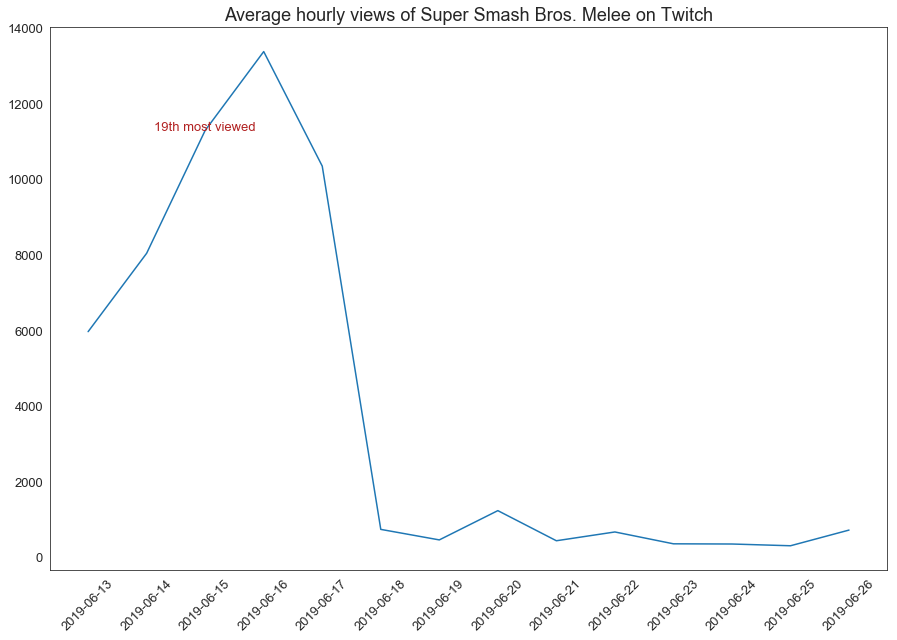

In [39]:
plot_twitch_daily('Super Smash Bros. Melee', dfd)

In [40]:
def plot_twitch_hourly(gn, df):
    gn_df = df[df.name == gn].sort_values('avgViewers', ascending = False)
    if gn_df.shape[0] == 0:
        print("No Data: Invalid Game Name")
        return None
    gn_df['date'] = gn_df['day'] + '-' + gn_df['month'] + '-' + gn_df['year'] + ' ' + gn_df['hour']
    gn_df['date'] =  pd.to_datetime(gn_df['date'], format='%d-%m-%Y %H')
    
    # fill missing values between times
    gn_df.index = gn_df['date']
    gn_df = gn_df.resample('H', how='mean')
    gn_df['date'] = gn_df.index
    gn_df.index = pd.RangeIndex(len(gn_df.index))
    gn_df['avgViewers'] = gn_df['avgViewers'].fillna(0) # fill avgViewers NAs with 0
    
    # restore old index
    gn_df.index = pd.RangeIndex(len(gn_df.index))
    #gn_df['date'] = gn_df['date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M:%S'))
    
    sns.set_style("white")
    # rcParams['font.family'] = 'garamond'
    # rcParams['font.family'] = 'helvetica'
    rcParams['font.family'] = 'serif'
    
    fig = plt.figure(figsize=(15, 10))
     
    ax = sns.lineplot(x="date", y="avgViewers", data=gn_df)
    
    ax.set_title("Average hourly views of {} on Twitch".format(gn), fontsize=18)
    
    ax.set_ylabel('', fontsize=16)
    ax.set_xlabel('', fontsize=20)
    
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    
    plt.xticks(rotation=45, fontsize = 13)
    plt.yticks(fontsize = 13)
    
    top = np.argmin(gn_df['hourly_top'])
    top2 = np.argmax(gn_df['avgViewers'])
    
    ax.text(gn_df.date[top], gn_df.avgViewers[top],
        add_text_twitch(int(gn_df.hourly_top[top])),
        horizontalalignment='center', size='large', color='firebrick', fontsize = 13)
    
    if int(top) not in range(int(top2)-10, int(top2)+10):
        ax.text(gn_df.date[top2], gn_df.avgViewers[top2],
                add_text_twitch(int(gn_df.hourly_top[top2])),
                horizontalalignment='center', size='large', color='firebrick', fontsize = 13)
    
    plt.show()

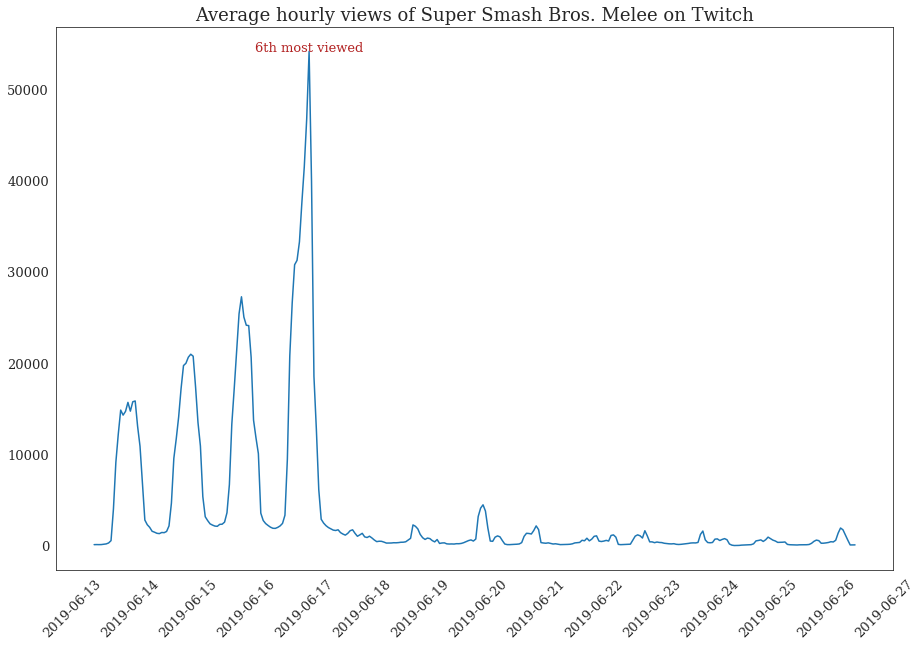

In [42]:
plot_twitch_hourly("Super Smash Bros. Melee", dfh)

# Twitter

### Get Data

In [44]:
pipeline_twit = [{"$group": {"_id": {"name": "$query",
                                     "day": { "$dayOfMonth": "$date" },
                                     "month": { "$month": "$date" },
                                     "year": { "$year": "$date" }},
                             "tot_retweets": { "$sum": "$retweets" },
                             "tot_likes": { "$sum" : "$likes"},
                             "tweet_count" : { "$sum": 1 }
                             }},
                 {"$sort": {"_id": 1} }]

In [45]:
result_twit = list(db.twitter.aggregate(pipeline_twit))

In [47]:
dft= json_normalize(result_twit)
dft= dft.rename(index=str, columns={"_id.name": "name", "_id.day": "day","_id.month": "month","_id.year": "year"})
dft= dft[['name', 'day', 'month', 'year', 'tot_retweets', 'tot_likes', 'tweet_count']]
dft.head()

,name,day,month,year,tot_retweets,tot_likes,tweet_count
0,apex legends,13,6,2019,54,349,96
1,apex legends,14,6,2019,140,1022,200
2,apex legends,15,6,2019,160,1154,200
3,apex legends,16,6,2019,173,1491,169
4,apex legends,17,6,2019,112,692,16


#### Add daily top

In [48]:
dft['daily_top'] = dft.sort_values(['day', 'month', 'year', 'tot_likes'], 
                                   ascending=[True, True, True, False]
                                  ).groupby(['day', 'month', 'year']).cumcount()
dft['daily_top'] = dft['daily_top'] + 1
dft.head()

,name,day,month,year,tot_retweets,tot_likes,tweet_count,daily_top
0,apex legends,13,6,2019,54,349,96,10
1,apex legends,14,6,2019,140,1022,200,12
2,apex legends,15,6,2019,160,1154,200,13
3,apex legends,16,6,2019,173,1491,169,9
4,apex legends,17,6,2019,112,692,16,27


## Viz Twitter

In [49]:
def add_text_tweet(i):
    i = str(i)
    suff = 'th'
    if i[-1] == '1':
        suff = 'st'
    if i[-1] == '2':
        suff = 'nd'
    if i[-1] == '3':
        suff = 'rd'
    suff = suff + ' most liked'
    return(i+suff)

def plot_twitter_daily(gn, df):
    ogn = gn
    gn = gn.lower()
    gn_df = df[df.name == gn].sort_values('tot_likes', ascending = False)
    gn_df['day'] = gn_df['day'].astype(str)
    gn_df['month'] = gn_df['month'].astype(str)
    gn_df['year'] = gn_df['year'].astype(str)
    gn_df['date'] = gn_df['day'] + '-' + gn_df['month'] + '-' + gn_df['year']
    gn_df['date'] =  pd.to_datetime(gn_df['date'], format='%d-%m-%Y')
    
    # fill missing values between times
    gn_df.index = gn_df['date']
    gn_df = gn_df.resample('D', how='mean')
    gn_df['date'] = gn_df.index
    gn_df.index = pd.RangeIndex(len(gn_df.index))
    gn_df['tot_likes'] = gn_df['tot_likes'].fillna(0) # fill avgViewers NAs with 0
    
    # restore old index
    gn_df.index = pd.RangeIndex(len(gn_df.index))
    #gn_df['date'] = gn_df['date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M:%S'))
    
    sns.set_style("white")
    # rcParams['font.family'] = 'garamond'
    # rcParams['font.family'] = 'helvetica'
    rcParams['font.family'] = 'serif'
    
    fig = plt.figure(figsize=(15, 10))
     
    ax = sns.lineplot(x="date", y="tot_likes", data=gn_df#, marker="o"
                     )
    
    ax.set_title("Daily total tweet likes for {} on Twitter".format(ogn), fontsize=18)
    
    ax.set_ylabel('', fontsize=16)
    ax.set_xlabel('', fontsize=20)
    
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    
    plt.xticks(rotation=45, fontsize = 13)
    plt.yticks(fontsize = 13)
    
    top = np.argmin(gn_df['daily_top'])
    top2 = np.argmax(gn_df['tot_likes'])
    
    ax.text(gn_df.date[top], gn_df.tot_likes[top],
        add_text_tweet(int(gn_df.daily_top[top])),
        horizontalalignment='center', size='large', color='firebrick', fontsize = 13)
    
    if int(top) not in range(int(top2)-10, int(top2)+10):
        ax.text(gn_df.date[top2], gn_df.tot_likes[top2],
                add_text_tweet(int(gn_df.daily_top[top2])),
                horizontalalignment='center', size='large', color='firebrick', fontsize = 13)
    
    plt.show()

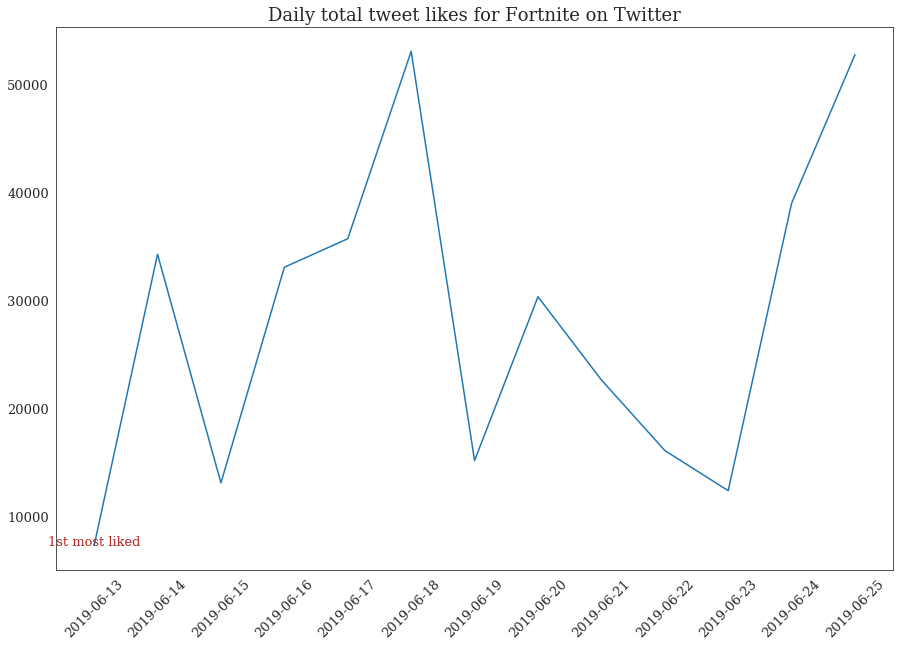

In [50]:
plot_twitter_daily('Super Smash Bros. Melee', dft)

# Close server

In [51]:
if server.is_active:
    server.stop()